In [1]:
from google.colab import files
from google.colab import drive
import os

# optional: mount Google Drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/w207/
!ls

/content/gdrive/My Drive/w207
melanoma


In [3]:
!pip install python-resize-image

In [4]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 20kB/s 
     |████████████████████████████████| 3.8MB 38.9MB/s 
     |████████████████████████████████| 512kB 37.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d8c6e0a41d9bd9c8826ff663684c525abb556463c3a207b4d7535613bdfea5c7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [5]:
import pandas as pd
import numpy as np
from pylab import *
from PIL import Image
from resizeimage import resizeimage
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [6]:
train_csv=pd.read_csv('/content/gdrive/My Drive/Kaggle/melanoma/csv/train.csv')

In [7]:
%cd /content/gdrive/My Drive/Kaggle/melanoma/jpeg/train/

/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train


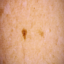

In [10]:
img=Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/ISIC_0015719.jpg")
img=img.resize((64, 64))
img

Support Vector Machines are supervised learning models which are often used in classification, regression, and outlier detection. They are effective in high dimesnional spaces, and still effective in cases where the number of dimensions is greater than the number of samples. A subset of training points are used in the decision function, called support vectors, which is beneficial in terms of memory efficiency. The ability to use different kernel functions makes this model versatile. Common kernels are provided in Python packages, but it's also possible to specify custom-made kernels. 

In [11]:
train_csv[train_csv['target']==1]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1
...,...,...,...,...,...,...,...,...
32969,ISIC_9955163,IP_7507212,male,55.0,upper extremity,melanoma,malignant,1
33000,ISIC_9963177,IP_1165806,male,70.0,torso,melanoma,malignant,1
33014,ISIC_9967383,IP_7887363,male,60.0,upper extremity,melanoma,malignant,1
33050,ISIC_9978107,IP_2860540,male,65.0,lower extremity,melanoma,malignant,1


In the case of this dataset, when target==1, the image of the mole is a melanoma and when target==0, the image of the model is non-malignant.

In [12]:
malignant_df=train_csv[train_csv['target']==1][:500]
benign_df=train_csv[train_csv['target']==0][:30000]#.sample(n=500)

malignant_df_dev=train_csv[train_csv['target']==1][500:]
benign_df_dev=train_csv[train_csv['target']==0][30000:30500]#.sample(n=len(malignant_df_dev))

train_labels_mal=malignant_df['target'].tolist()
image_names_mal=malignant_df['image_name'].tolist()
train_labels_ben=benign_df['target'].tolist()
image_names_ben=benign_df['image_name'].tolist()

dev_labels_mal=malignant_df_dev['target'].tolist()
dev_image_names_mal=malignant_df_dev['image_name'].tolist()
dev_labels_ben=benign_df_dev['target'].tolist()
dev_image_names_ben=benign_df_dev['image_name'].tolist()

In [13]:
train_data=[]
train_labels=[1 for image in image_names_mal]+[0 for image in image_names_ben]
for image in image_names_mal:
  try:
    im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
    im=array(im.resize((32, 32)))
    train_data.append(im)
  except:
    pass


 
for image in image_names_ben:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image)) #"/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/{}.jpg"
      im=array(im.resize((32, 32)))
      train_data.append(im)
    except:
      pass

pd.DataFrame(list(zip(train_data, train_labels)), columns =['train_data', 'train_labels']).to_csv("train_data.csv")


dev_data=[]
dev_labels=[1 for image in dev_image_names_mal]+[0 for image in dev_image_names_ben]

for image in dev_image_names_mal:
  try:
    im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
    im=array(im.resize((32, 32)))
    dev_data.append(im)
  except:
    pass

for image in dev_image_names_ben:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
      im=array(im.resize((32, 32)))
      dev_data.append(im)
    except:
      pass

pd.DataFrame(list(zip(dev_data, dev_labels)), columns =['dev_data', 'dev_labels']).to_csv("dev_data.csv")

In [14]:
train_data=array(train_data)
dev_data=array(dev_data)
X_train = train_data.reshape(train_data.shape[0], 32, 32, 3)
X_dev = dev_data.reshape(dev_data.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_dev = X_dev.astype('float32')

X_train /= 255
X_dev /= 255

Y_train = np_utils.to_categorical(train_labels, 2)
Y_dev = np_utils.to_categorical(dev_labels, 2)

X_train_svm=[]
for i in X_train:
  nsamples, nx, ny = i.shape
  d2_train_dataset = i.reshape((nsamples*nx*ny))
  X_train_svm.append(d2_train_dataset)

X_dev_svm=[]
for i in X_dev:
  nsamples, nx, ny = i.shape
  d2_train_dataset = i.reshape((nsamples*nx*ny))
  X_dev_svm.append(d2_train_dataset)

target_names=[str(x) for x in list(np.unique(dev_labels))]

### Base Model Using Tensorflow

In [15]:
X = np.array(X_train_svm)
Y = np.array(train_labels)
example_id = np.array(['%d' % i for i in range(len(Y))])

x_column_name = 'x'
example_id_column_name = 'example_id'

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X, example_id_column_name: example_id},
    y=Y,
    num_epochs=None,
    shuffle=True)

svm = tf.contrib.learn.SVM(
    example_id_column=example_id_column_name,
    feature_columns=(tf.contrib.layers.real_valued_column(
        column_name=x_column_name, dimension=49152),),
    l2_regularization=0.1)

svm.fit(input_fn=train_input_fn, steps=100)
svm_metrics = svm.evaluate(input_fn=train_input_fn, steps=100)
print("Loss", svm_metrics['loss'], "\nAccuracy", svm_metrics['accuracy'])

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please switch to tf.contrib.estimator.*_head.


Instructions for updating:
Please switch to tf.contrib.estimator.*_head.


Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*


Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*


Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.


Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f46b7b74860>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpj6k4rshw', '_session_creation_timeout_secs': 7200}


INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f46b7b74860>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpj6k4rshw', '_session_creation_timeout_secs': 7200}


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


Instructions for updating:
This class is deprecated. To UPDATE or USE linear optimizers, please check its latest version in core: tensorflow_estimator/python/estimator/canned/linear_optimizer/.


Instructions for updating:
This class is deprecated. To UPDATE or USE linear optimizers, please check its latest version in core: tensorflow_estimator/python/estimator/canned/linear_optimizer/.


Instructions for updating:
This class is deprecated. To UPDATE or USE linear optimizers, please check its latest version in core: tensorflow_estimator/python/estimator/canned/linear_optimizer/.


Instructions for updating:
This class is deprecated. To UPDATE or USE linear optimizers, please check its latest version in core: tensorflow_estimator/python/estimator/canned/linear_optimizer/.


Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.


Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpj6k4rshw/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpj6k4rshw/model.ckpt.


INFO:tensorflow:loss = 1.5011284, step = 1


INFO:tensorflow:loss = 1.5011284, step = 1


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpj6k4rshw/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpj6k4rshw/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0.


INFO:tensorflow:Loss for final step: 0.0.


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Created variable linear/bias_weight:0, with device=


INFO:tensorflow:Starting evaluation at 2020-07-26T09:24:02Z


INFO:tensorflow:Starting evaluation at 2020-07-26T09:24:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpj6k4rshw/model.ckpt-100


INFO:tensorflow:Restoring parameters from /tmp/tmpj6k4rshw/model.ckpt-100


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Finished evaluation at 2020-07-26-09:24:03


INFO:tensorflow:Finished evaluation at 2020-07-26-09:24:03


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.9609375, global_step = 100, loss = 0.18356203


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.9609375, global_step = 100, loss = 0.18356203


Loss 0.18356203 
Accuracy 0.9609375


### Base Models Using SVM in Scikit Learn with Differing Kernels

Instead of using an even number of examples from each of the benign and malignant datasets, weights will be used in the following models -- giving more weights to the malignant examples.

In [16]:
num_benign_samples=30000
num_malignant_samples=500
weights=[round(num_benign_samples/num_malignant_samples) for x in range(500)]+[1 for x in range(num_benign_samples)]

In [ ]:
for weight in (1,60,90):
  for kern in ('rbf','linear', 'poly'):
    weights=[weight for x in range(num_malignant_samples)]+[1 for x in range(num_benign_samples)]
    svm =  Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel=kern,gamma='auto'))])
    svm.fit(X_train_svm, train_labels, **{'svc__sample_weight': weights})

    prediction_svm=svm.predict(X_dev_svm) #predicting with dev_data
    print('Weights={}, Kernel={}'.format(weight, kern))
    print(classification_report(dev_labels, prediction_svm, target_names=target_names))

    fpr, tpr, thresholds = metrics.roc_curve(dev_labels, prediction_svm, pos_label=1)
    print("AUC",metrics.auc(fpr, tpr))

Kernel=rbf
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       0.00      0.00      0.00        84

    accuracy                           0.86       584
   macro avg       0.43      0.50      0.46       584
weighted avg       0.73      0.86      0.79       584

AUC 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Kernel=linear
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       500
           1       0.55      0.14      0.23        84

    accuracy                           0.86       584
   macro avg       0.71      0.56      0.57       584
weighted avg       0.82      0.86      0.82       584

AUC 0.5614285714285714
Kernel=poly
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       500
           1       1.00      0.01      0.02        84

    accuracy                           0.86       584
   macro avg       0.93      0.51      0.47       584
weighted avg       0.88      0.86      0.79       584

AUC 0.5059523809523809
Kernel=rbf
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       500
           1       0.48      0.25      0.33        84

    accuracy                           0.85       584
   macro avg       0.68      0.60      0.62  

Looking at the results for the different SVM kernels, it appears rbf or poly will work best. The sklearn SVM models do not work as well as the tensor flow model. I will work on a more custom tensor flow model soon.